In [2]:
#Add required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.neighbors import NearestNeighbors
import io
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

#Loading data and displaying it
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
movies = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')
ratings.head(5)
movies.head(5)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [3]:
#Resize and make changes in the data to reach the desired shape
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()
#fill number with zero
final_dataset.fillna(0,inplace=True)
final_dataset.head()


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Delete damaged and unusable data
num_user_voted = ratings.groupby('movieId')['rating'].agg('count')
num_movies_voted = ratings.groupby('userId')['rating'].agg('count')

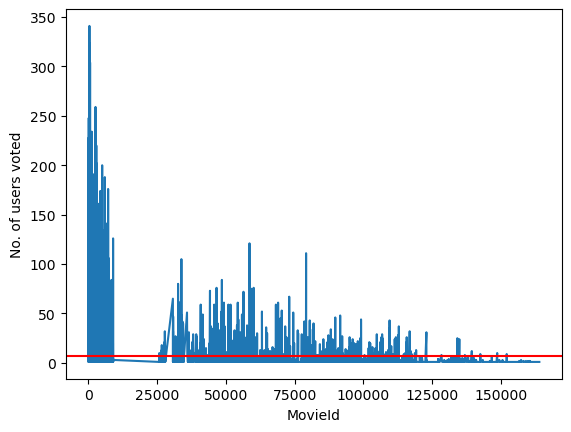

In [5]:
#Show number of votes to a movie
plt.plot(num_user_voted.index,num_user_voted)
plt.axhline(y=7,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

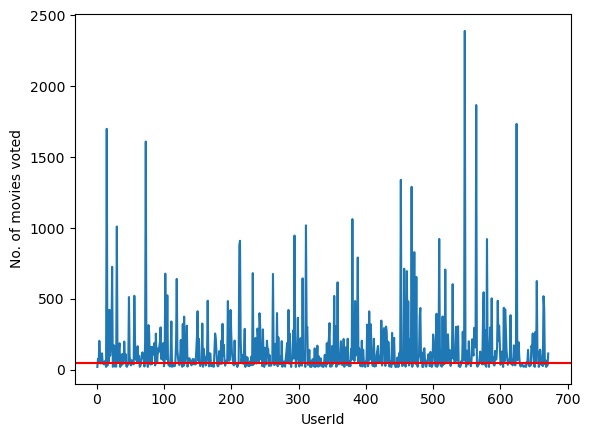

In [6]:
#Show numbers of votes a user 
plt.plot(num_movies_voted.index,num_movies_voted)
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of movies voted')
plt.show()

In [7]:
#Removing movies that have less than ten people voted for them
#Removing users who voted for less than 50 movies
final_dataset = final_dataset.loc[num_user_voted[num_user_voted > 10].index,:]
final_dataset = final_dataset.loc[:,num_movies_voted[num_movies_voted > 50].index]
final_dataset

userId,2,3,4,5,7,8,12,13,15,17,...,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0
122904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#reindexing dataset
final_dataset.reset_index(inplace=True)
final_dataset

userId,movieId,2,3,4,5,7,8,12,13,15,...,655,656,658,659,660,662,664,665,667,671
0,1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
2,3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2078,122900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0
2079,122904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2080,134130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2081,134853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Show cells of matrix isn't zero
csr_data = scipy.sparse.csr_matrix(final_dataset.values)
print(csr_data)

  (0, 0)	1.0
  (0, 5)	3.0
  (0, 8)	5.0
  (0, 9)	2.0
  (0, 12)	3.0
  (0, 13)	3.5
  (0, 16)	3.0
  (0, 17)	5.0
  (0, 18)	4.0
  (0, 27)	4.0
  (0, 28)	4.0
  (0, 31)	4.0
  (0, 38)	5.0
  (0, 39)	3.0
  (0, 40)	4.0
  (0, 41)	5.0
  (0, 42)	5.0
  (0, 43)	3.5
  (0, 44)	5.0
  (0, 45)	3.0
  (0, 46)	4.0
  (0, 48)	2.0
  (0, 51)	3.5
  (0, 53)	3.0
  (0, 55)	5.0
  :	:
  (2081, 157)	5.0
  (2081, 162)	2.5
  (2081, 170)	4.0
  (2081, 178)	5.0
  (2081, 189)	4.0
  (2081, 228)	4.5
  (2081, 252)	3.5
  (2081, 298)	5.0
  (2081, 323)	3.5
  (2081, 344)	4.0
  (2081, 393)	5.0
  (2081, 399)	4.5
  (2082, 0)	139385.0
  (2082, 9)	2.5
  (2082, 31)	4.0
  (2082, 43)	3.5
  (2082, 44)	4.0
  (2082, 156)	4.0
  (2082, 170)	3.0
  (2082, 228)	4.0
  (2082, 233)	4.0
  (2082, 285)	3.5
  (2082, 305)	3.5
  (2082, 344)	3.5
  (2082, 393)	4.0


In [10]:
#Using your knn's algorithm to find the nearest neighbors to a given data
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [11]:
#movie reccomedtion engine
movie_name = "Four Rooms"
#search in movies dataset to find movie you want
movie_list = movies[movies['original_title'].str.contains(movie_name)]  
movie_list
#check the movie is exist or not
if len(movie_list):
    #find id of movie
    movie_idx= movie_list.iloc[0]['id']
    #print(movie_idx)
    #find id of movie in reindexed dataset
    movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
    #print(movie_idx)
    #use knn algorint to find distance of neighbors
    distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=11)
    #sort distancees 
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = []
    #loop in recommended movie
    for val in rec_movie_indices:
        movie_idx = final_dataset.iloc[val[0]]['movieId']
        #print(movie_idx)
        #check movie is exist in dataset or not
        idx = movies[movies['id'] == movie_idx]
        if idx.empty:
            continue
       # print(idx["original_title"].values[0])
    #add to final recommedtion 
        recommend_frame.append({'Title':idx["original_title"].values[0],"original_language":idx["original_language"].values[0],"overview":idx["overview"].values[0],"runtime":idx["runtime"].values[0]})
    #print(len(recommend_frame))
    #display recommention 
    df = pd.DataFrame(recommend_frame,index=range(1,len(recommend_frame)+1))
    display(df)
else:
    print("chert o pert nagho")

,Title,original_language,overview,runtime
1,2001: A Space Odyssey,en,Humanity finds a mysterious object buried bene...,149.0
2,Metropolis,de,In a futuristic city sharply divided between t...,153.0
3,Star Wars,en,Princess Leia is captured and held hostage by ...,121.0
